# Histopathologic Cancer Detection
Based on images taken from digital pathology scans, we will train a model in an attempt to accurately predict wether or not metastatic cancer, cancer that has spread from its original source, is present. The data consists of a train and test set of images, with labels. 

### Exploratory Data Analysis
We will first analyze and study the data using OpenCV along with the usual data visualization python libraries. I am choosing OpenCV because it is a powerful open source library with advanced features. 

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# let's first take a look at labels

train_labels = pd.read_csv('cancer-data/train_labels.csv')

train_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [3]:
data_type_train = train_labels['label'].dtype
print("Data type of 'label' column:", data_type_train)

Data type of 'label' column: int64


In [4]:
sum_train_unique_labels = train_labels['label'].value_counts().sum()

print("Sum of unique values in the 'label' column:", sum_train_unique_labels)

Sum of unique values in the 'label' column: 220025


In [5]:
samples = pd.read_csv('cancer-data/sample_submission.csv')

samples.head()

id  label
0  0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5      0
1  95596b92e5066c5c52466c90b69ff089b39f2737      0
2  248e6738860e2ebcf6258cdc1f32f299e0c76914      0
3  2c35657e312966e9294eac6841726ff3a748febf      0
4  145782eb7caa1c516acbe2eda34d9a3f31c41fd6      0

In [6]:
data_type = samples['label'].dtype
print("Data type of 'label' column:", data_type)

Data type of 'label' column: int64


In [7]:
sum_unique_labels = samples['label'].value_counts().sum()

print("Sum of unique values in the 'label' column:", sum_unique_labels)

Sum of unique values in the 'label' column: 57458


In [8]:
print(train_labels.shape)
print(samples.shape)

(220025, 2)
(57458, 2)


In [9]:
# check for any necessary data cleaning needed

duplicates = train_labels[train_labels.duplicated()]
print(duplicates)

null_vals = train_labels.isnull()
null_count = null_vals.sum()
print(null_count)

Empty DataFrame
Columns: [id, label]
Index: []
id       0
label    0
dtype: int64


In [10]:
total_positive_cases = (train_labels['label'] ==1 ).sum()
print("Total positive metastatic cancer cases out of 220,025:", total_positive_cases)

Total positive metastatic cancer cases out of 220,025: 89117


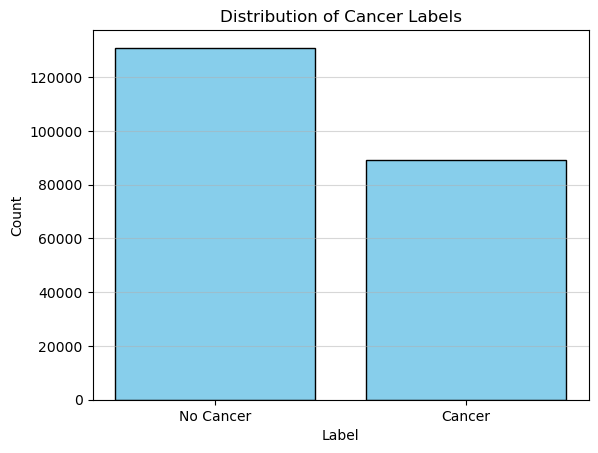

In [11]:
# plotting cases on histogram
plt.hist(train_labels['label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, color='skyblue', edgecolor='black')

plt.title('Distribution of Cancer Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer', 'Cancer'])

plt.grid(axis='y', alpha=0.5)
plt.show()

In [12]:
train = "cancer-data/train"
test = "cancer-data/test"
print("Number of training images: {}".format(len(os.listdir(train))))
print("Number of test images: {}".format(len(os.listdir(test))))

Number of training images: 220025
Number of test images: 57458


In [13]:
# taking a look at some images
def display_random_images(image_dir, num_images=10, rows=2, cols=5):
    image_ids = os.listdir(image_dir)
    np.random.shuffle(image_ids)
    image_ids = image_ids[:num_images]
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    
    for i, filename in enumerate(image_ids):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        row = i // cols
        col = i % cols
        
        axes[row, col].imshow(img)
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Image {i+1}')
    
    plt.tight_layout()
    plt.show()

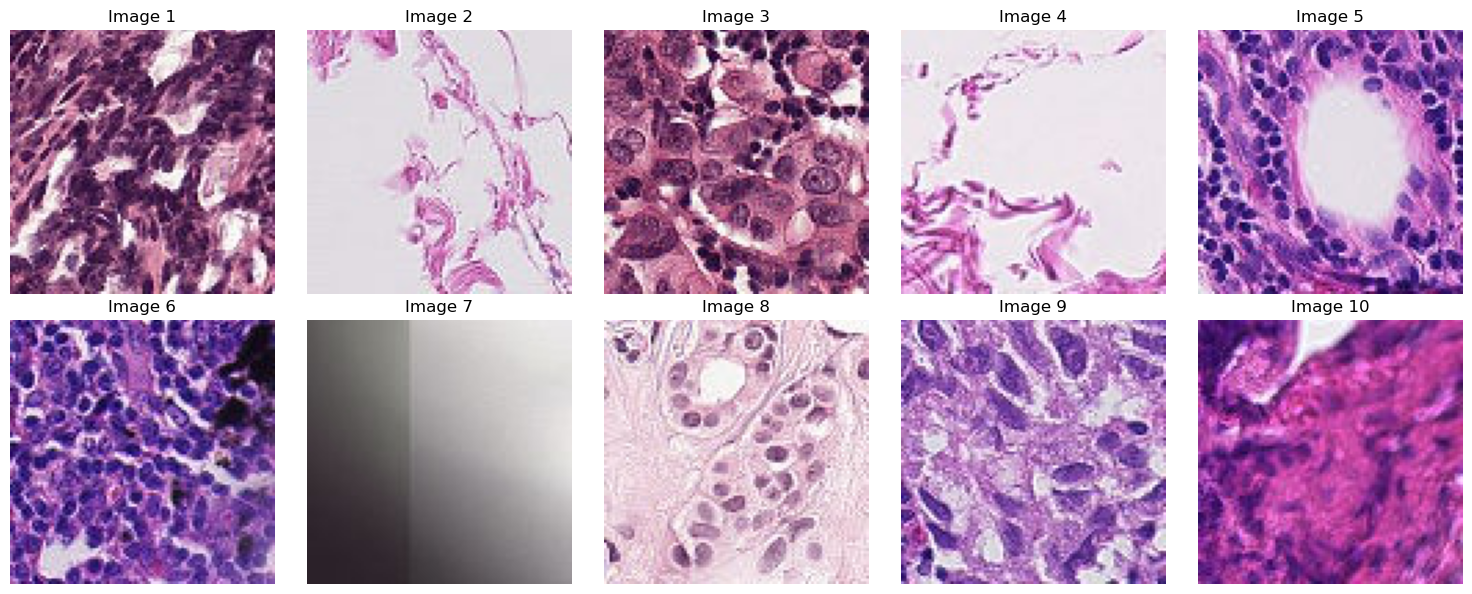

In [14]:
display_random_images(train)

In [15]:
# checking size of image

first_img = "cancer-data/train/0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif"

img = cv2.imread(first_img, cv2.IMREAD_UNCHANGED)

height, width = img.shape[:2]
print("Shape of the first image:")
print("Height:", height)
print("Width:", width)

Shape of the first image:
Height: 96
Width: 96


In [16]:
# now looking at images specifically of cancerous vs non-cancerous

cancer = train_labels.loc[train_labels['label']==1]['id'].values 
non_cancer = train_labels.loc[train_labels['label']==0]['id'].values 

In [17]:
def plot_fig(ids, title, train_dir, nrows=5, ncols=10):

    fig, ax = plt.subplots(nrows, ncols, figsize=(18, 6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    
    for i, j in enumerate(ids[:nrows * ncols]):
        fname = os.path.join(train_dir, j + '.tif')
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        cv2.rectangle(img, (0, 0), (95, 95), (255, 255, 255), 1)
        
        ax[i // ncols, i % ncols].imshow(img)
        ax[i // ncols, i % ncols].axis('off')

    plt.suptitle(title, y=0.94)
    plt.show()

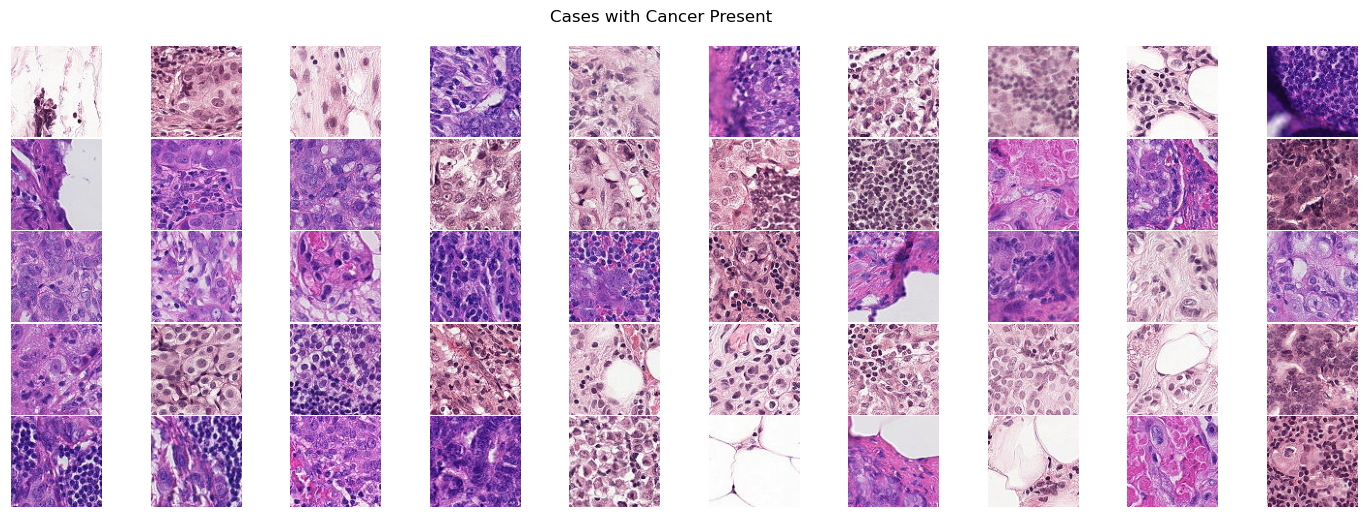

In [18]:
plot_fig(cancer, "Cases with Cancer Present", train)

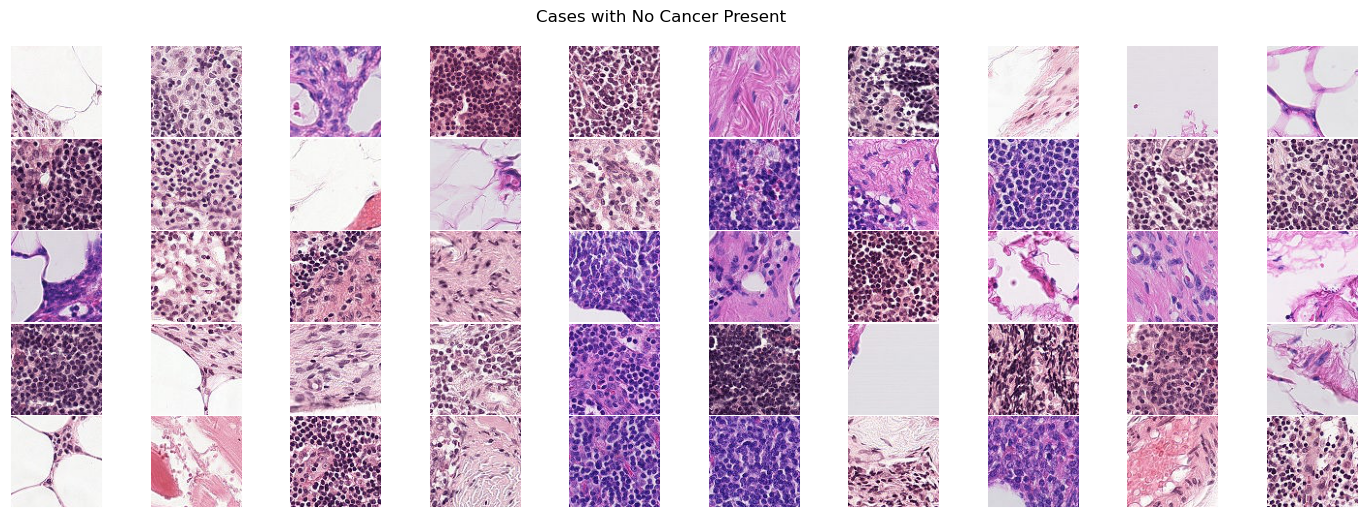

In [19]:
plot_fig(non_cancer, "Cases with No Cancer Present", train)

### EDA Findings
- Very large set of training data
- Images are 96x96x3
- Data has plenty of cancer cases to learn from
- About 40% of training set are positive for cancer instances

## Model Building
For this task, I will follow a variation of the VGG Net architecture for my model, with some changes. The output layer will be a sigmoid function since we are dealing with binary classification. 

In [20]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models
from keras.metrics import AUC
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [21]:
train_labels = train_labels.astype(str)

In [22]:
train_labels['id'] += '.tif'

In [23]:
# only using 8000 images for training due to enormous number of images
train_labels_sampled = train_labels.sample(n=8000, random_state=42)

In [24]:
train_labels_sampled.head()

id label
107796  d293308913e4a40cebb809d986aa9add65a76bfa.tif     0
11942   fcd55f03496afb4b11598d9c2231e86da318e723.tif     1
163858  5c983c8f14afeffdb098b9f3cbb68488a802b957.tif     0
184810  71bf03e8530348e57ec07d8ce2052f215390c997.tif     0
150958  1533406000e26663c5fadac3bcc3e38285a45bb3.tif     1

In [25]:
# preparing images for training using keras tools

# normalizing
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_sampled,
    directory=train,  
    x_col="id",   
    y_col="label",      
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary"  
)

Found 8000 validated image filenames belonging to 2 classes.


In [26]:
# preparing for testing

samples = samples.astype(str)

In [27]:
samples['id'] += '.tif'

In [28]:
# only using 2000 images for training due to enormous number of images
test_labels_sampled = samples.sample(n=2000, random_state=42)

In [29]:
# normalizing and adding labels to images
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels_sampled,
    directory=test,  
    x_col="id",   
    y_col="label",      
    target_size=(96, 96),
    batch_size=32, 
)

Found 2000 validated image filenames belonging to 1 classes.


### Justification for architecture chosen
As mentioned, this will somewhat follow the VGG Net architecture, 2 conv layers, max pooling, later followed by 3 conv layers, then fully connected and a sigmoid output function because we are dealing with binary classification. The number of filters chose starting with 32 is due to computational constraints. This is also the reasoning behind the 256 total number as opposed to the 4096 typically seen in the VGG Net architecture. The goal here is to follow the means and method of the VGG Net architecture while also within the constraints of my macbook m2 pro's computational power. 

The choice for adam as an optomizer was arbitrary, somewhat but I have seen much success reported using this optomizer. I limited the learning rate to .001 because the default adam learning rate is much smaller. 

Relu was chosen also due to it's success in machine learning. 

No strides were implemented due to the smaller 96x96 image size. 

Sigmoid was chosen since the target is labeled 0 or 1 

In [30]:
def vgg_model(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model
    
img_width, img_height = 96, 96
input_shape = (img_width, img_height, 3)
model = vgg_model(input_shape)

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(train_generator, batch_size=32, epochs=10)

prediction_labels = model.predict(test_generator)

/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,529 (8.04 MB)

 Trainable params: 2,106,529 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/sethmartin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 188ms/step - accuracy: 0.5982 - loss: 0.6662
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.6893 - loss: 0.5897
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step - accuracy: 0.7806 - loss: 0.4829
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7868 - loss: 0.4667
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.7866 - loss: 0.4751
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.7830 - loss: 0.4629
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.7955 - loss: 0.4483
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.8102 - loss: 0.4258
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.8156 - loss: 0.4161
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.8276 - loss: 0.4010
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


In [40]:
from sklearn.metrics import accuracy_score

predictions = (prediction_labels > 0.5).astype(int).flatten() 

true_labels = test_generator.labels 

# accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy}')

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

Test Accuracy: 0.484
              precision    recall  f1-score   support

           0       1.00      0.48      0.65      2000
           1       0.00      0.00      0.00         0

    accuracy                           0.48      2000
   macro avg       0.50      0.24      0.33      2000
weighted avg       1.00      0.48      0.65      2000

[[ 968 1032]
 [   0    0]]


/Users/sethmartin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Analysis
Based on the accuracy results, my model seems to be overfitting the data. I will fine tune the model my adding some regularization methods. For this second model, I will use droput layers in an attempt to improve test accuracy. 

I am choosing dropout due to its simple implementation as well as its randomization. 

Additionally I am also adding some L2 regularization due to it's robustness to outliers compared to L1.

In [42]:
from tensorflow.keras import regularizers

def vgg_model_2(input_shape):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))  # Dropout layer to prevent overfitting
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout layer to prevent overfitting
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

img_width, img_height = 96, 96
input_shape = (img_width, img_height, 3)
model_2 = vgg_model_2(input_shape)

learning_rate_2 = 0.001

optimizer_2 = Adam(learning_rate=learning_rate)

model_2.compile(optimizer=optimizer_2, loss='binary_crossentropy', metrics=['accuracy'])

model_2.summary()

history_2 = model_2.fit(train_generator, batch_size=32, epochs=10)

prediction_labels_2 = model.predict(test_generator)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 17, 17, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,106,529 (8.04 MB)

 Trainable params: 2,106,529 (8.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 196ms/step - accuracy: 0.5845 - loss: 0.9317
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.7237 - loss: 0.5933
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.7575 - loss: 0.5407
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.7698 - loss: 0.5192
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 201ms/step - accuracy: 0.7858 - loss: 0.4966
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.7870 - loss: 0.4997
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.7847 - loss: 0.4901
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.7957 - loss: 0.4740
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.7865 - loss: 0.4905
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - accuracy: 0.7863 - loss: 0.4850
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


In [43]:
predictions_2 = (prediction_labels_2 > 0.5).astype(int).flatten() 

true_labels_2 = test_generator.labels 

# accuracy
accuracy_2 = accuracy_score(true_labels_2, predictions_2)
print(f'Test Accuracy: {accuracy_2}')

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels_2, predictions_2))
print(confusion_matrix(true_labels_2, predictions_2))

Test Accuracy: 0.6995
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      2000
           1       0.00      0.00      0.00         0

    accuracy                           0.70      2000
   macro avg       0.50      0.35      0.41      2000
weighted avg       1.00      0.70      0.82      2000

[[1399  601]
 [   0    0]]


/Users/sethmartin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sethmartin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Conclusion
With regularization testing accuracy was greatly improved to almost 70%. This indicatest that the overfitting properties for the original model were minimized. 

The training sample was small compared to the original dataset. I believe the model would have been vastly improved with a much larger training sample accompanied with deeper architecture, but due to computational constraints, I limited a lot of these variables. 